In [1]:
%matplotlib inline
import sys
sys.path.append("..")

In [2]:
import random

import deeptrack as dt
from deeptrack import extras

import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf

extras.datasets.load("ParticleTracking")

tracker_input_size = 128

# Can increase to get better validation accuracy at the cost of additional load time
max_frames_to_load = 2000

ParticleTracking already downloaded! Use force_overwrite=True to redownload the dataset.


In [3]:
K = tf.keras.backend


start = np.zeros((10, 10))

angle = 0

a = dt.Affine(rotate=1)(start)
b = dt.Affine(rotate=1+angle)(start)

def get_transform_matrix(base_image, new_image):
    t0 = base_image.get_property("translate")[2::-1]
    r0 = base_image.get_property("rotate") * 2
    s0 = base_image.get_property("scale")

    t1 = new_image.get_property("translate")[2::-1]
    r1 = new_image.get_property("rotate") * 2
    s1 = new_image.get_property("scale")

    rmat0 = np.array([[np.cos(r0), np.sin(r0)], [-np.sin(r0), np.cos(r0)]]) * s0
    rmat1 = np.array([[np.cos(r1), np.sin(r1)], [-np.sin(r1), np.cos(r1)]]) * s1

    rmat = np.linalg.inv(rmat0) @ rmat1
    dt = (np.array(t1) - t0) @ rmat1

    return np.array(
        [rmat[0, 0], rmat[0, 1], dt[0], rmat[1, 0], rmat[1, 1], dt[1], 0, 0]
    )

T = tf.constant(np.array([get_transform_matrix(a, a), get_transform_matrix(a, b)]).astype(np.float32))
P = tf.constant(np.array([[0, 0, np.cos(angle), np.sin(angle)], [0, 0, np.cos(angle*3), np.sin(angle*3)]]).astype(np.float32))


T = K.reshape(T[:, :6], (-1, 2, 3))
transformation_matrix = T[:, :2, :2]
normed_transf_matrix, _ = tf.linalg.normalize(transformation_matrix, axis=(1, 2))
relative_normed_transf_matrix = tf.matmul(
    tf.linalg.inv(normed_transf_matrix[:1]), normed_transf_matrix
)
true_relative_cos = relative_normed_transf_matrix[:, 0, 0]
true_relative_sin = relative_normed_transf_matrix[:, 0, 1]

# Processing the prediction
rotation_prediction = P[:, 2:4]  # cos(th), sin(th)
norm_factor = K.sum(K.square(rotation_prediction), axis=-1, keepdims=True)
normed_predictions = rotation_prediction / norm_factor
relative_cos = (
    normed_predictions[:1, 0] * normed_predictions[:, 0]
    + normed_predictions[:1, 1] * normed_predictions[:, 1]
)

relative_sin = (
    normed_predictions[:1, 0] * normed_predictions[:, 1]
    - normed_predictions[:1, 1] * normed_predictions[:, 0]
)

cos_err = K.square(true_relative_cos - relative_cos)
sin_err = K.square(true_relative_sin - relative_sin)
norm_err = K.square(norm_factor - 1)

e = K.mean(cos_err + sin_err + norm_err) / 3

print(f"Calculated true relative angle (cos) {(np.arccos(true_relative_cos.numpy()) * 360 / 2 / np.pi)[-1]:.2f} deg")
print(f"Calculated true relative angle (sin) {(np.arcsin(true_relative_sin.numpy()) * 360 / 2 / np.pi)[-1]:.2f} deg")
print(f"Calculated predicted relative angle (cos) {(np.arccos(relative_cos.numpy()) * 360 / 2 / np.pi)[-1]:.2f} deg")
print(f"Calculated predicted relative angle (sin) {(np.arcsin(relative_sin.numpy()) * 360 / 2 / np.pi)[-1]:.2f} deg")
print(f"Calculated error {e:.2f}")

Calculated true relative angle (cos) 0.02 deg
Calculated true relative angle (sin) -0.00 deg
Calculated predicted relative angle (cos) 0.00 deg
Calculated predicted relative angle (sin) 0.00 deg
Calculated error 0.00


In [4]:
class CrescentMoon(dt.Ellipse):
    def get(self, *inp, radius, offset, **kwargs):
        ellipse = super().get(*inp, radius=radius, **kwargs)
        offset = np.round(offset).astype(np.int)
        other = dt.Affine(translate=offset, mode="constant").resolve(ellipse)
        ellipse[np.array(other > 0)] = 0
        
        return ellipse
        
class Rectangle(dt.Scatterer):
    def get(self, *inp, width, height, **kwargs):
        return np.ones((round(width), round(height), 1))
        

In [5]:
imsize = 64

commons = dt.DummyFeature(
    image_size=imsize,
    position=lambda image_size: image_size / 2 + np.random.randn(2) * 2
)

fluorescence_microscope = dt.Fluorescence(
    NA=0.8,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, 64, 64)
)

poisson_noise = dt.Poisson(
    snr=lambda: np.random.rand()*7 + 20,
    background=0.1
)


# particle = CrescentMoon(radius=1e-6, offset=(5, 0), position=commons.position)
particle = Rectangle(height=18, width=12, position=commons.position)

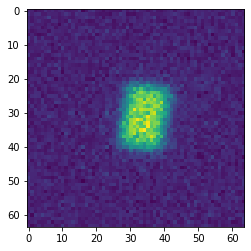

In [6]:
arguments = dt.Arguments(
    noise_level=10
)

pipeline = (
    fluorescence_microscope(particle)
    >> dt.Affine(rotate=lambda:np.random.rand() * 2 * np.pi)
    >> dt.NormalizeMinMax() 
    + 0.2
) >> dt.Poisson(snr=arguments.noise_level, background=0.2) >> dt.NormalizeMinMax()


pipeline.plot()

In [7]:
dataset = [pipeline.update().resolve() for _ in range(500)]
dataset_labels = [np.mean(d.get_property("rotate", get_one=False), axis=0) for d in dataset]

In [10]:
def rotational_consistency(T, P):
    T = K.reshape(T[:, :6], (-1, 2, 3))
    transformation_matrix = T[:, :2, :2]
    normed_transf_matrix, _ = tf.linalg.normalize(transformation_matrix, axis=(1, 2))
    relative_normed_transf_matrix = tf.matmul(
        tf.linalg.inv(normed_transf_matrix[:1]), normed_transf_matrix
    )
    
    relative_normed_transf_matrix = tf.matmul(relative_normed_transf_matrix, relative_normed_transf_matrix)
    true_relative_cos = relative_normed_transf_matrix[:, 0, 0]
    true_relative_sin = relative_normed_transf_matrix[:, 0, 1]

    # Processing the prediction
    rotation_prediction = P[:, 2:4]  # cos(th), sin(th)
    norm_factor = K.sqrt(K.sum(K.square(rotation_prediction), axis=-1, keepdims=True))
    normed_predictions = rotation_prediction / norm_factor
    
    relative_cos = (
        normed_predictions[:1, 0] * normed_predictions[:, 0]
        + normed_predictions[:1, 1] * normed_predictions[:, 1]
    )

    relative_sin = (
        normed_predictions[:1, 0] * normed_predictions[:, 1]
        - normed_predictions[:1, 1] * normed_predictions[:, 0]
    )
    
#     _relative_sin = 2*relative_cos*relative_sin
#     _relative_cos = relative_cos**2 - relative_sin**2

    cos_err = K.abs(true_relative_cos - relative_cos)
    sin_err = K.abs(true_relative_sin - relative_sin)
    norm_err = K.square(norm_factor - 1)

    return K.mean(cos_err + sin_err + norm_err) / 3

model = dt.models.AutoTracker(
    input_shape=(imsize, imsize, 1),
    symmetries=1,
    loss=rotational_consistency
)

training_pipeline = dt.Value(
    value=lambda:random.choice(dataset[:10])
)

#         generator

model.fit(training_pipeline, batch_size=8, epochs=30)

Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 6s 6ms/step - loss: 0.4872
Epoch 2/30
800/800 [==============================] - 5s 6ms/step - loss: 0.4331
Epoch 3/30
800/800 [==============================] - 5s 6ms/step - loss: 0.0973
Epoch 4/30
800/800 [==============================] - 5s 6ms/step - loss: 0.0585
Epoch 5/30
800/800 [==============================] - 5s 6ms/step - loss: 0.0481
Epoch 6/30
800/800 [==============================] - 5s 6ms/step - loss: 0.0398
Epoch 7/30
800/800 [==============================] - 5s 6ms/step - loss: 0.0377
Epoch 8/30
800/800 [==============================] - 5s 6ms/step - loss: 0.0368
Epoch 9/30
800/800 [==============================] - 5s 6ms/step - loss: 0.0367
Epoch 10/30
800/800 [==============================] - 5s 6ms/step - loss: 0.0333
Epoch 11/30
800/800 [==============================] - 5s 6ms/step - loss: 0.0320
Epoch 12/30
800/800 [==============================] 

KeyboardInterrupt: 

In [ ]:
np.array(dataset).shape

0.03541907732135164


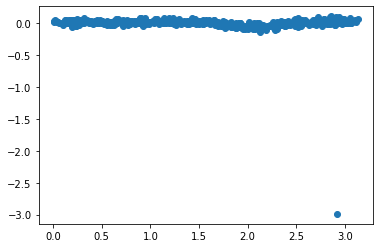

In [33]:
x = model.predict(np.array(dataset))

angle = np.arctan2(x[:, 3], x[:, 2]) / 2

dataset_labels = [np.mean(d.get_property("rotate", get_one=False), axis=0) % np.pi for d in dataset]

diff = (angle -dataset_labels)

diff = (diff - np.mean(diff) + np.pi / 2) % (np.pi)
diff = diff - np.mean(diff)

print(np.mean(np.abs(diff)))
plt.scatter(dataset_labels, diff)


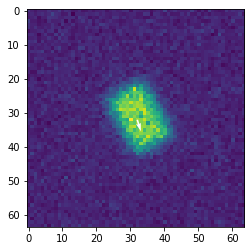

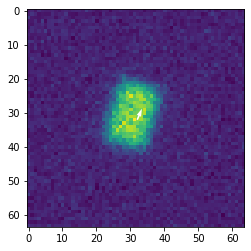

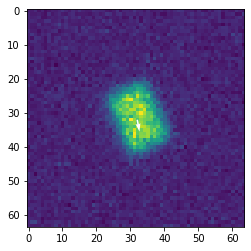

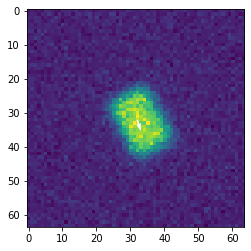

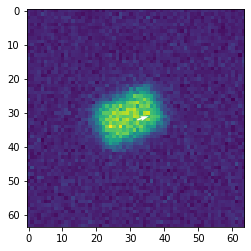

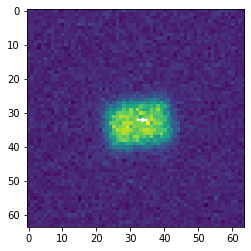

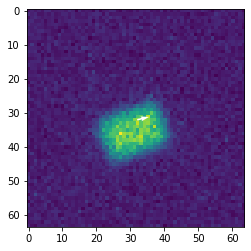

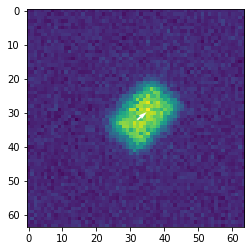

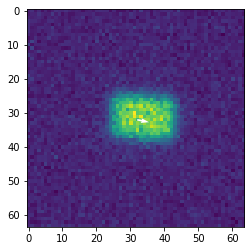

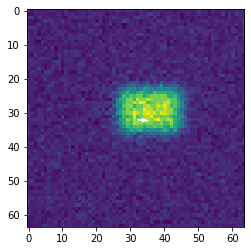

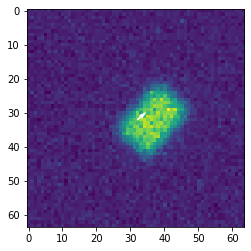

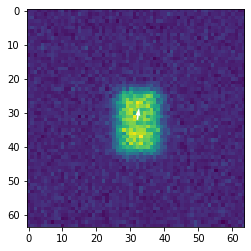

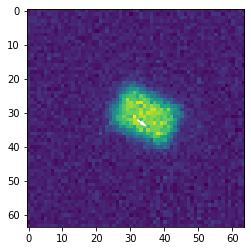

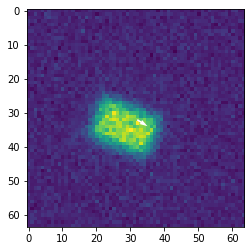

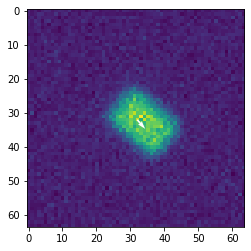

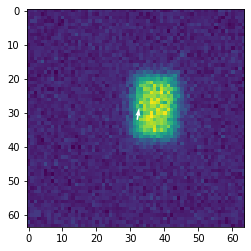

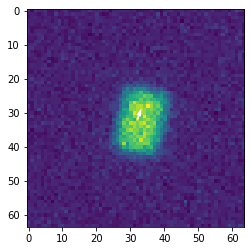

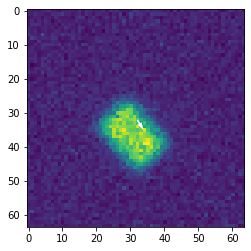

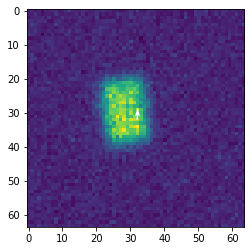

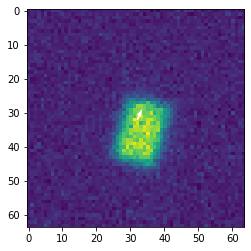

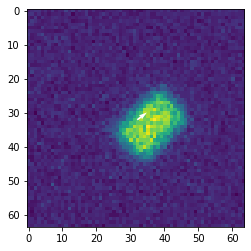

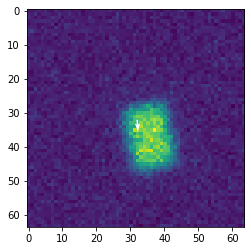

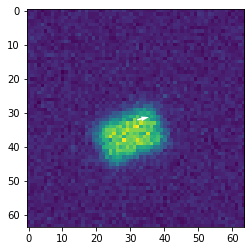

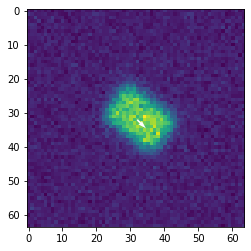

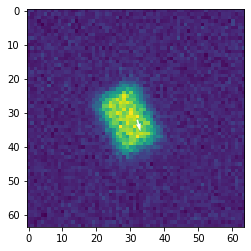

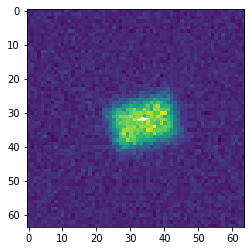

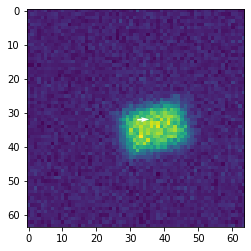

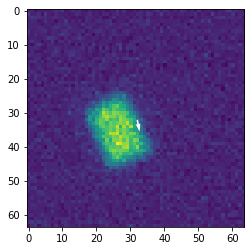

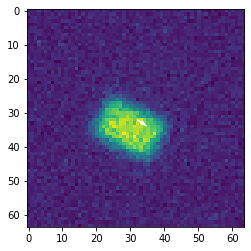

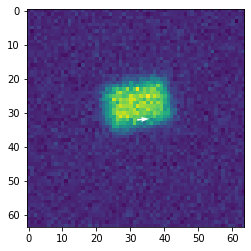

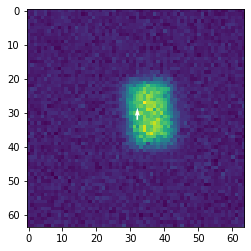

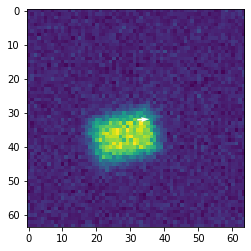

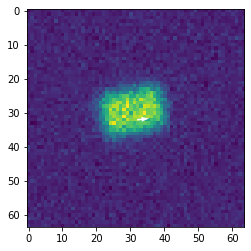

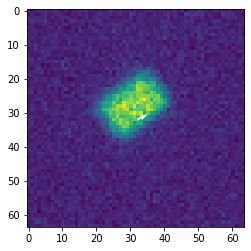

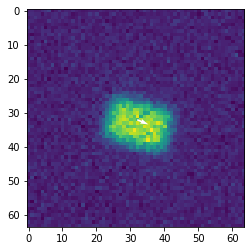

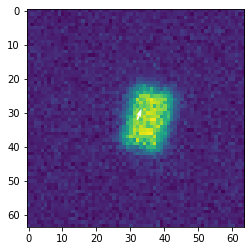

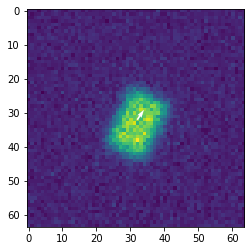

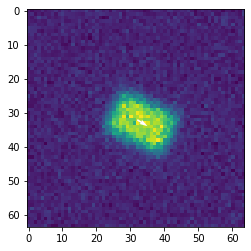

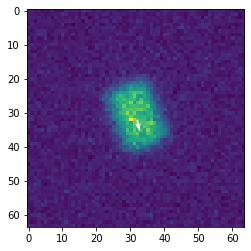

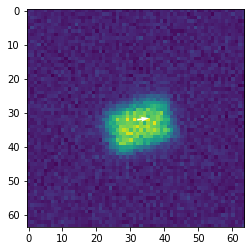

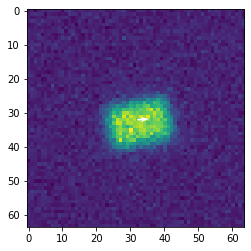

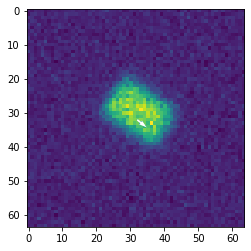

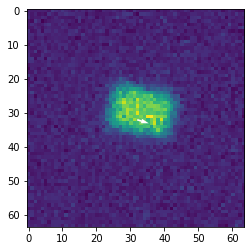

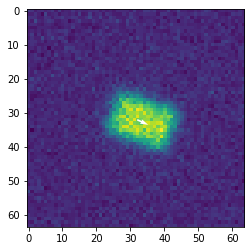

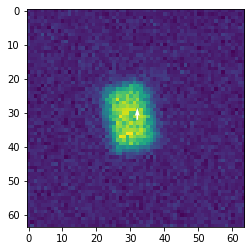

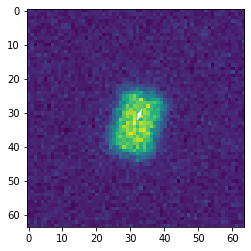

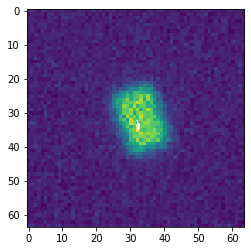

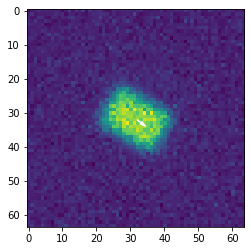

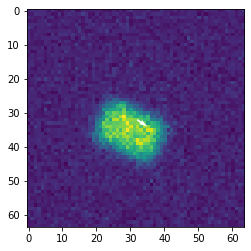

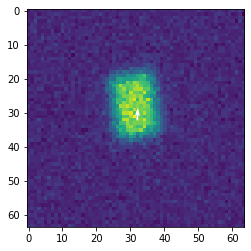

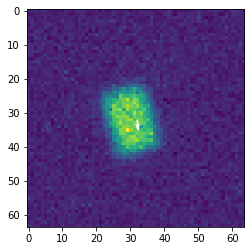

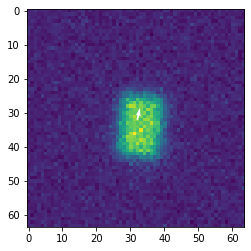

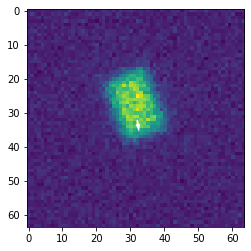

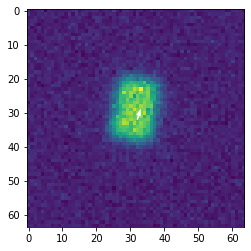

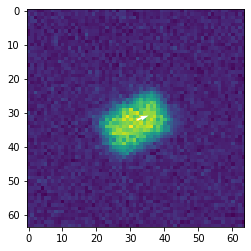

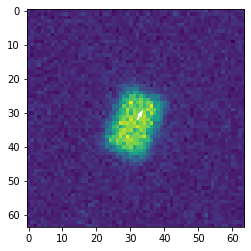

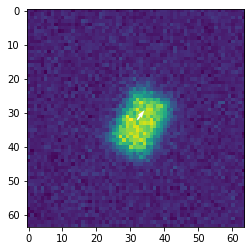

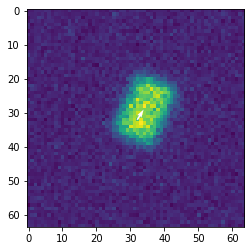

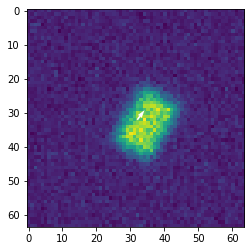

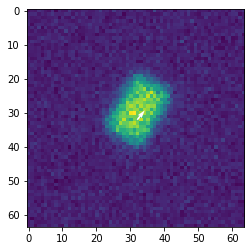

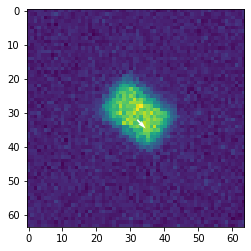

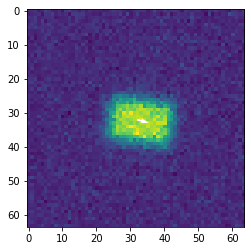

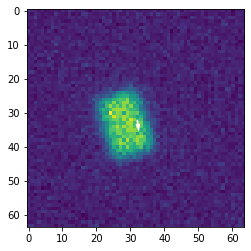

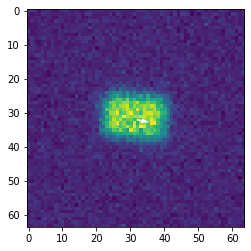

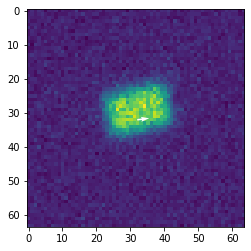

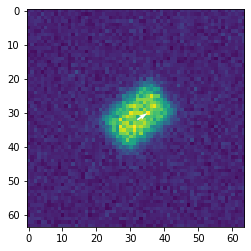

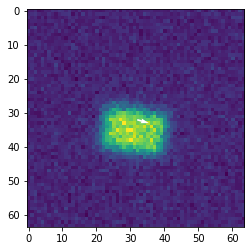

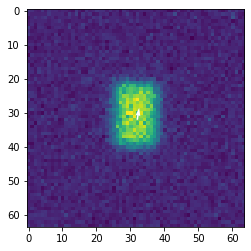

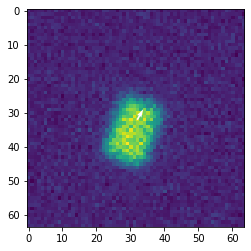

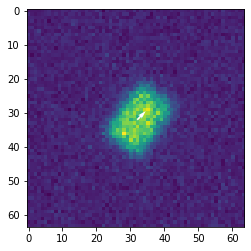

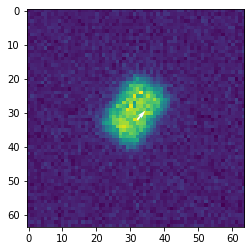

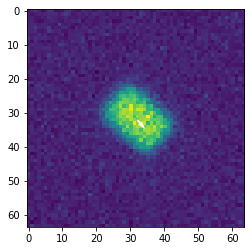

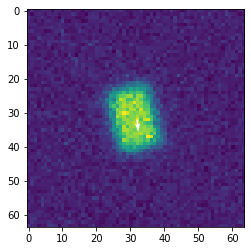

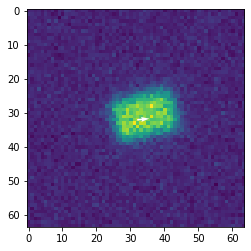

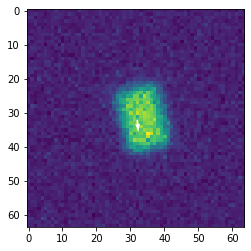

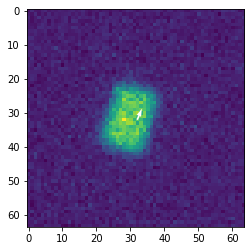

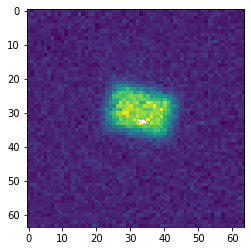

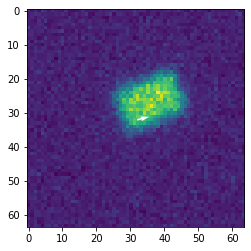

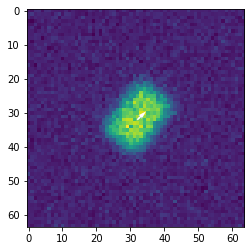

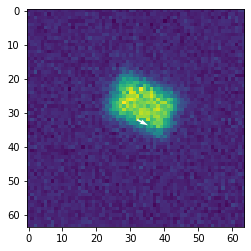

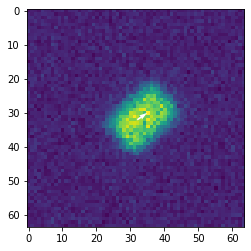

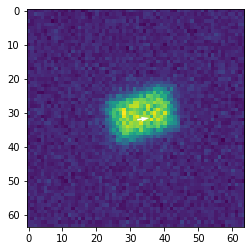

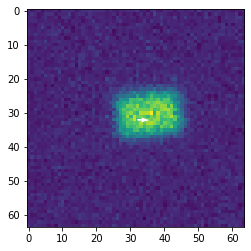

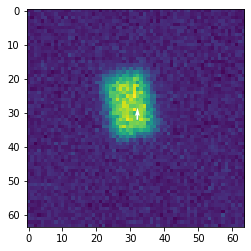

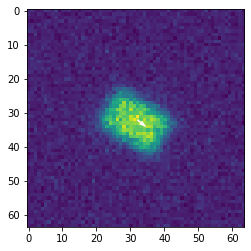

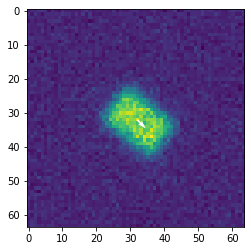

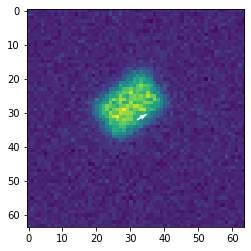

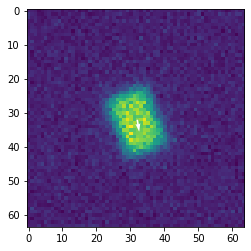

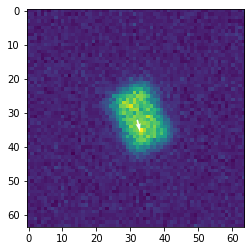

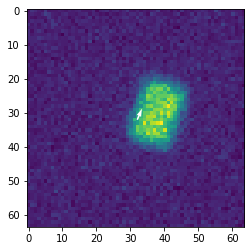

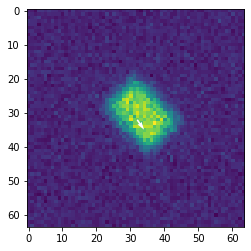

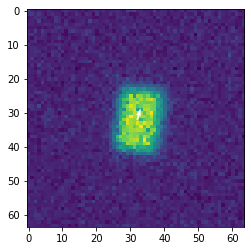

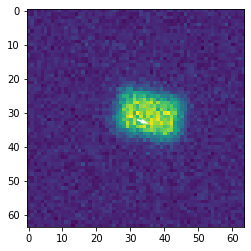

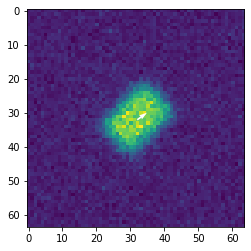

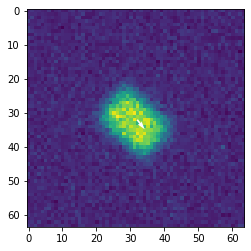

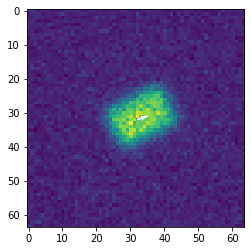

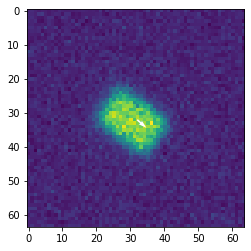

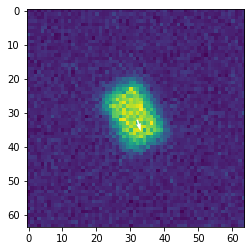

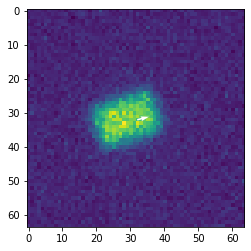

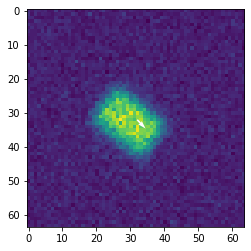

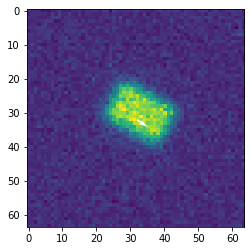

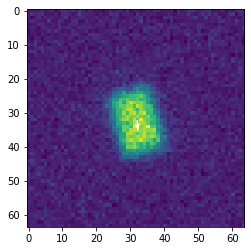

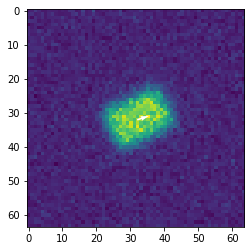

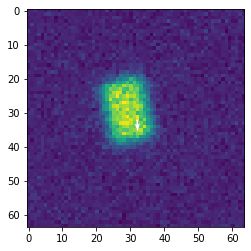

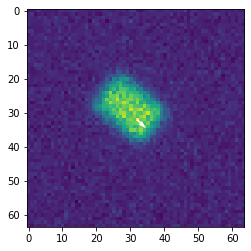

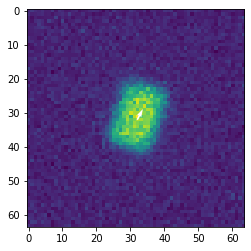

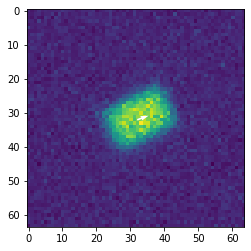

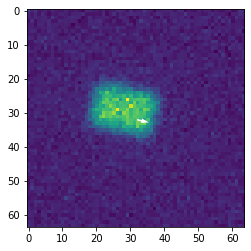

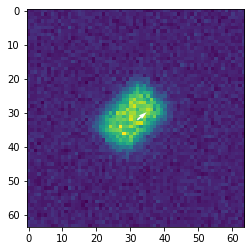

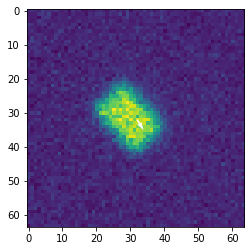

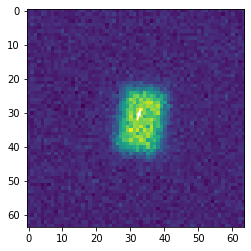

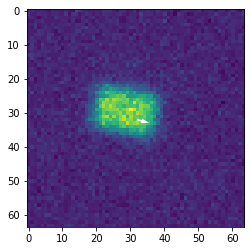

KeyboardInterrupt: 

In [30]:
for _x, y in zip(x, dataset):
    
    ang = np.arctan2(_x[3], _x[2]) / 2
    _x = np.cos(ang)
    _y = np.sin(ang)
    
    plt.imshow(y)
    plt.quiver([32], [32], [_x], [_y], color="w")
    plt.show()
    